# Analysis of Processed and Filtered Data

**Imports**

In [1]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt

In [66]:
def create_plot_comparison(year,disaster_type):
    
    if year == 2018 and disaster_type == 'storm':
        disaster_path_asia = 'data/'+str(year)+'_'+disaster_type+'_filtered_asia_csv.bz2'
        disaster_path_america = 'data/'+str(year)+'_'+disaster_type+'_filtered_america_csv.bz2'
        
        disaster_df = pd.read_csv(disaster_path_asia, parse_dates = ['date'], compression='bz2')
        disaster_df_2 = pd.read_csv(disaster_path_america, parse_dates = ['date'], compression='bz2')
        
        dscr_str = 'Asia'
        dscr_str_2 = 'America'

    else:
        disaster_path = 'data/'+str(year)+'_'+disaster_type+'_filtered_csv.bz2'
        disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
        
        dscr_str = ''
        
    climate_path = 'data/'+str(year)+'_'+disaster_type+'_climate_filtered_csv.bz2'
    climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')
    
    start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
    
    if year == 2018 and disaster_type == 'storm':
        start_disaster_2, end_disaster_2 = disaster_df_2.date.min(), disaster_df_2.date.max()
        
        start_disaster = min([start_disaster,start_disaster_2])
        end_disaster = min([end_disaster,end_disaster_2])
    
    start_climate, end_climate = climate_df.date.min(), climate_df.date.max()
    
    print("Disaster Dates: {} --- {}".format(
            start_disaster.strftime("%Y-%m-%d"), 
            end_disaster.strftime("%Y-%m-%d")))
    print("Climate Dates:  {} --- {}".format(
            start_climate.strftime("%Y-%m-%d"), 
            end_climate.strftime("%Y-%m-%d")))
    
    type_to_str = {
        'storm': str(year) + ' Storm ',
        'heat_wave': str(year) + ' Heat Wave ',
    } 
    
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    _, bins, _ = plt.hist(climate_df.date, bins=60, alpha=0.4, label='Climate Talk', log=True)
    plt.hist(disaster_df.date, bins=bins, alpha=0.7, label=type_to_str[disaster_type]+dscr_str+' Talk')
    
    if year == 2018 and disaster_type == 'storm':
        plt.hist(disaster_df_2.date, bins=bins, alpha=0.3, label=type_to_str[disaster_type]+dscr_str_2+' Talk')
    
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
    plt.legend(loc='upper left')
    plt.show()

In [67]:
disaster_type = 'heat_wave'

Disaster Dates: 2015-05-20 --- 2015-06-09
Climate Dates:  2015-04-29 --- 2015-06-20


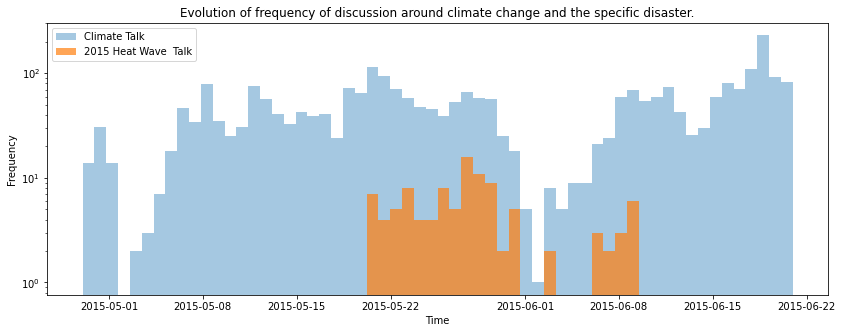

In [68]:
create_plot_comparison(2015,disaster_type)

Disaster Dates: 2016-04-17 --- 2016-05-20
Climate Dates:  2016-03-11 --- 2016-05-20


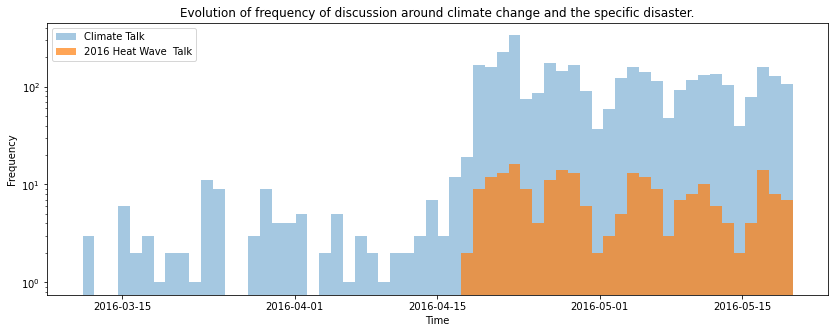

In [69]:
create_plot_comparison(2016,disaster_type)

Disaster Dates: 2017-01-31 --- 2017-02-24
Climate Dates:  2017-01-11 --- 2017-03-07


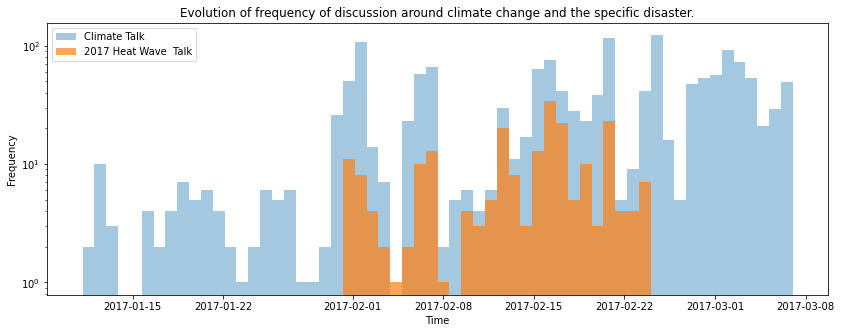

In [70]:
create_plot_comparison(2017,disaster_type)

Disaster Dates: 2018-07-01 --- 2018-08-03
Climate Dates:  2018-06-10 --- 2018-08-03


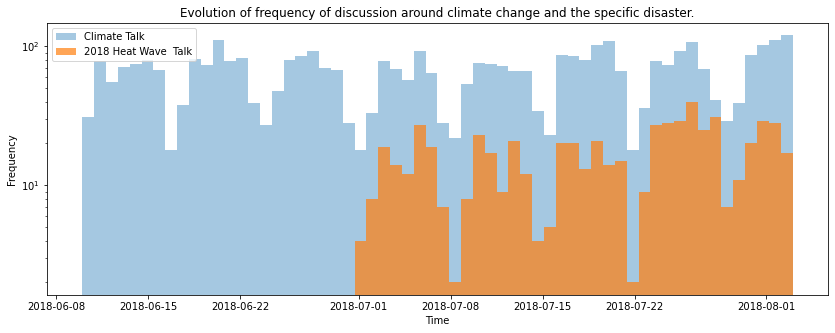

In [71]:
create_plot_comparison(2018,disaster_type)

Disaster Dates: 2019-07-19 --- 2019-08-05
Climate Dates:  2019-06-28 --- 2019-08-17


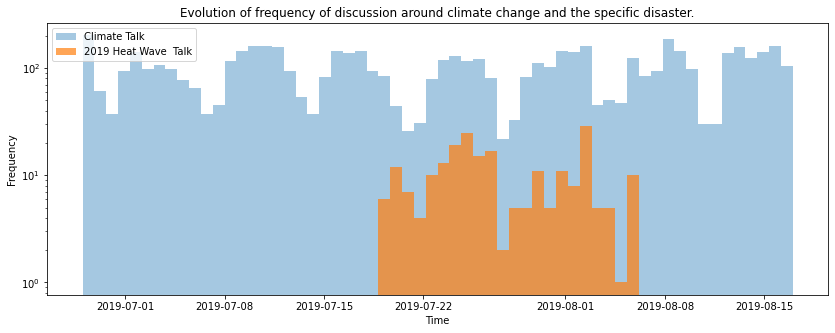

In [72]:
create_plot_comparison(2019,disaster_type)

Disaster Dates: 2019-09-02 --- 2020-01-31
Climate Dates:  2019-08-11 --- 2020-02-01


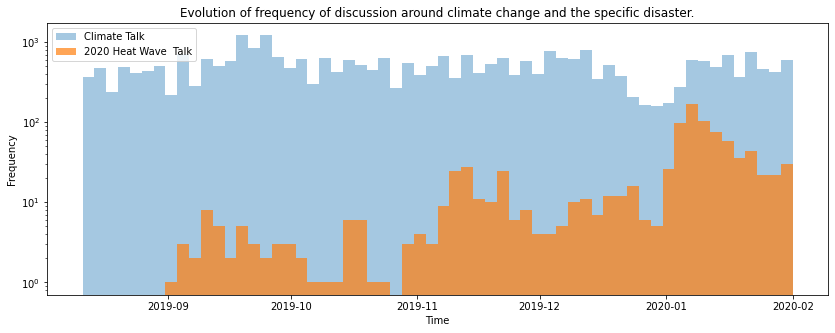

In [73]:
create_plot_comparison(2020,disaster_type)

In [74]:
disaster_type = 'storm'

Disaster Dates: 2015-10-22 --- 2015-11-06
Climate Dates:  2015-10-01 --- 2015-11-18


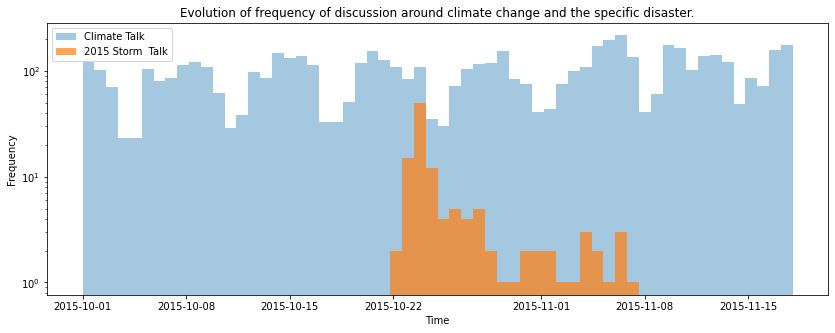

In [75]:
create_plot_comparison(2015,disaster_type)

Disaster Dates: 2016-02-20 --- 2016-02-26
Climate Dates:  2016-01-30 --- 2016-03-11


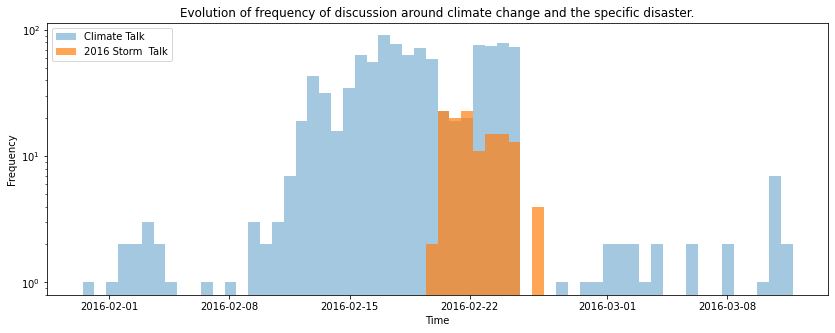

In [76]:
create_plot_comparison(2016,disaster_type)

Disaster Dates: 2017-08-25 --- 2017-09-08
Climate Dates:  2017-08-04 --- 2017-09-19


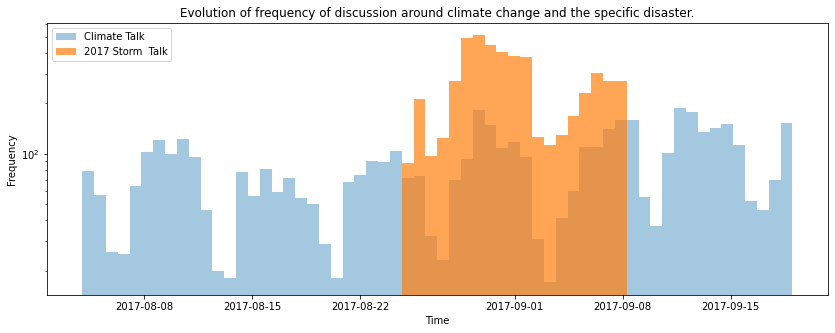

In [77]:
create_plot_comparison(2017,disaster_type)

Disaster Dates: 2018-09-10 --- 2018-09-27
Climate Dates:  2018-08-20 --- 2018-10-09


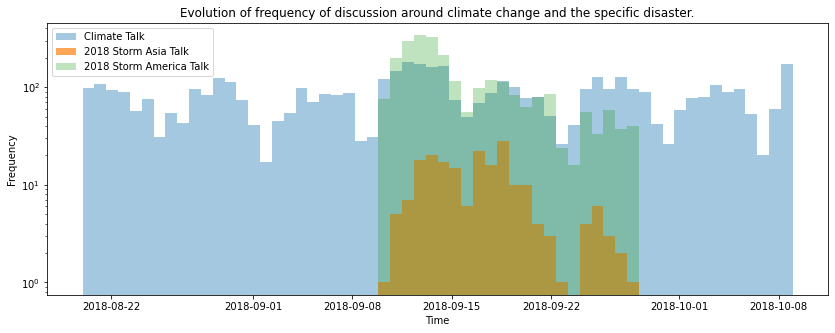

In [78]:
create_plot_comparison(2018,disaster_type)

Disaster Dates: 2019-10-12 --- 2019-10-27
Climate Dates:  2019-09-21 --- 2019-11-07


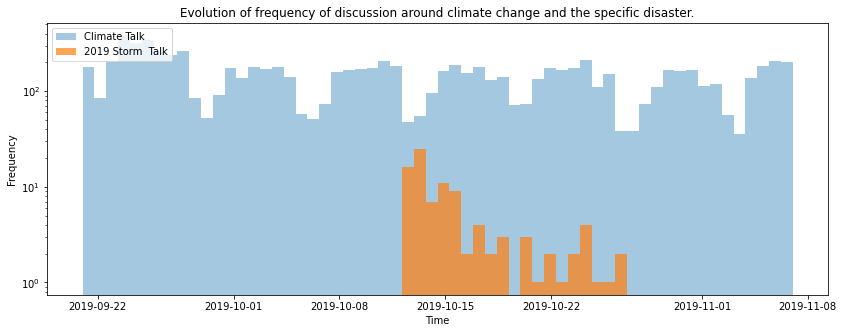

In [79]:
create_plot_comparison(2019,disaster_type)

Disaster Dates: 2019-12-02 --- 2019-12-12
Climate Dates:  2019-11-11 --- 2019-12-24


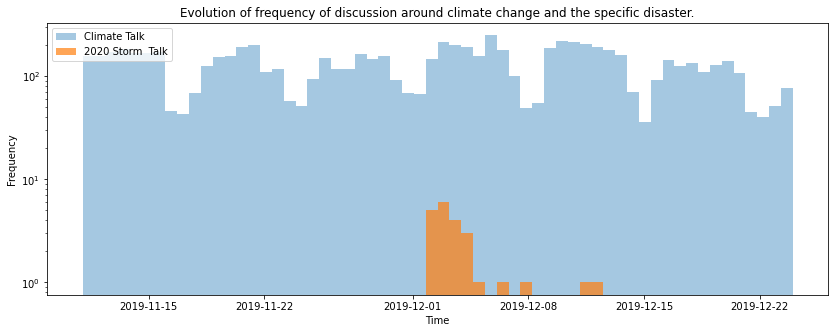

In [80]:
create_plot_comparison(2020,disaster_type)

**Original Code Here**

In [ ]:
YEAR = 2015
disaster_type = 'heat_wave'
disaster_path = 'data/'+str(YEAR)+'_'+disaster_type+'_filtered_csv.bz2'
climate_path = 'data/'+str(YEAR)+'_'+disaster_type+'_climate_filtered_csv.bz2'

In [ ]:
disaster_df = pd.read_csv(disaster_path, parse_dates = ['date'], compression='bz2')
climate_df = pd.read_csv(climate_path, parse_dates = ['date'], compression='bz2')

In [ ]:
start_disaster, end_disaster = disaster_df.date.min(), disaster_df.date.max()
start_climate, end_climate = climate_df.date.min(), climate_df.date.max()

In [ ]:
print("Disaster Dates: {} --- {}".format(start_disaster.strftime("%Y-%m-%d"), end_disaster.strftime("%Y-%m-%d")))
print("Climate Dates:  {} --- {}".format(start_climate.strftime("%Y-%m-%d"), end_climate.strftime("%Y-%m-%d")))

In [ ]:
fig = plt.gcf()
fig.set_size_inches(14, 5)
_, bins, _ = plt.hist(climate_df.date, bins=60, alpha=0.4, label='Climate Talk', log=True)
plt.hist(disaster_df.date, bins=bins, alpha=0.7, label='Disaster Talk')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Evolution of frequency of discussion around climate change and the specific disaster.")
plt.legend(loc='upper left')
plt.show()